# ML, MLP, MLPy!

### Foreword

> "Moderating on Discord is _hard_."
>
> **t**. _A lot of moderators_

Any moderation team on a Discord server can tell you that. Trolls, spammers, and all the highjinks involved in moderating hundred if not thousand of people is taxing. It is a day-long, year-round issue. Therefore the question outlined here is: Can this heavy process be helped?

The idea we will be interested in is dual: Can we build an image classification model, can a discord bot leverage that model for any purposes (here: moderating user posts). As such, this project will be about:

1. Improving our programming skills

2. Learning about Relational Databases

3. Teaching ourselves some advanced machine learning techniques

4. Building a proof-of-work chatroom bot that can read and evaluated pictures posted by users for a specific pupose (e.g. verifying if those pictures follow Discord's Terms of Service)

**This notebook is a summary of the whole process that went into this project**.

Let's see where this gets us!

### Acknowledgements

*Thanks to FreeCodeCamp for their PostGreSQL course available [here](https://www.youtube.com/watch?v=qw--VYLpxG4) and Linuxhint for their tutorial [here](https://linuxhint.com/postgresql_installation_guide_ubuntu_20-04/)*.

*Thanks to Derpibooru's team for providing their [REST API](https://www.derpibooru.org/pages/api) and overall access to their data.*

### 0. Library Imports

In [1]:
import pandas as pd
from IPython.display import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from modules import run_inference

## 1. Building our working database using postgreSQL and a REST API

The database that was used throughout this project is based on a .pgdump file that is freely provided by the Derpibooru team on their [dedicated page](https://www.derpibooru.org/pages/data_dumps). The database as at *November 11th, 2020*, requires about 35Gb of storage to be restored via postgreSQL. 

Several .py scripts were created to better handled this step:

- ``download_dump.py``: Provide a function to search for the most recent .pgdump download link available then downloads the data into a target_folder (libraries used: *urllib*, *pathlib*, *datetime*)

- ``pgdump_send_commands_to_psql.py``: Provides functions to send postgreSQL commands from python to the local PSQL engine to access our restored database (libraries used: *psycopg2*, *configparser*)

- ``pgdump_restore.py``: Provides a function to restore a database from a .pgdump file (libraries used: *subprocess*, *os*, *shlex*; script used: ``pgdump_send_commands_to_psql.py``)

- ``pgdump_save_db.py``: Provides a function to save a database into a .pgdump file (libraries used: *subprocess*, *os*, *shlex*, *datetime*; script used: ``pgdump_send_commands_to_psql.py``)

The scripts are available in the folder ``modules``. 

The process goes as such:

1. downloads the .pgdump file from the source

2. deletes existing instances of databases that could be construed as the downloaded one

3. restores the newly downloaded database from its .pgdump format

4. extracts the data we want to keep from the database and drop all other tables. We keep:
    - image records, which related image is formatted as: .png, .PNG, .jpg, .JPEG, .jpeg
    - tag ids matching the image records kept above
    - tag names matching the tag ids kept above


5. saves a copy of this new database as a .pgdump (in case of a mistake, etc.)

## 2. Building a dataset from our working database

Following the previous step, we now need to build a dataset. To do so, we need to create a .csv file that will list the attributes of images we want to include in the dataset. Once that file is created, we can proceed to scrap the Derpibooru website for those pictures. 

Several .py scripts were created to better handled this step:

- ``make_csv.py``:  Provides a function to query the previously created database to retrieve a **random** list of image ids and urls to be stored in a .csv file. It returns the path to the folder where the .csv is stored (script used: ``pgdump_send_commands_to_psql.py``). The function requires three arguments:
    1. a **list** of tag names (e.g. safe, shipping, etc.) used to filter out
    2. a number of images to query (e.g. 50000)
    3. a target folder where the dataset .csv will be stored)
    
    
- ``download_images.py``: Provides a function that queries derpibooru.org and retrieves images based on the urls retrieved via the function above. At this moment, url specifies that images are requested in 'medium' size (libraries used: *urllib*, *csv*, *time*, *os*; script used: ``pgdump_send_commands_to_psql.py``).

The scripts are available in the folder ``modules``. 

The process goes as such:

1. creates a dataset list by requesting the postgreSQL database for a specified number of randomly selected images
2. scraps the source website for the selected pictures and stores them in folders named with the tag_id requested

### How to create a binary dataset?

To create a binary dataset, we perform the step above twice:

1. we create 2 lists of pictures stored as the .csv files:
    - each file lists a randomly selected set of images (no pictures can be shared between the two lists, which can be ensured when the tags are mutually exclusive)
    - the two lists should be of even size
    
    
2. we download each sets of pictures, which will be automatically stored in subfolder named after their specified tag ids

**warning**: A lot of pictures might be present in the Derpibooru dump database, but they are not hosted anymore -- having been either removed or renamed. As such, downloading pictures has a high failure rate and the script ``downlad_images.py`` has been built to handle those edge cases. .csv files containing the list of images that failed to download are created during the process.

**remark**: Based on preliminary data (attempted download of 100,000k), the average failure rate is about **11.5%**. A way to handle this high failure rate would be to filter out those failing picture during the creation of the database (Step 1.4). Further understanding of available table attributes in the .pgdump is needed.

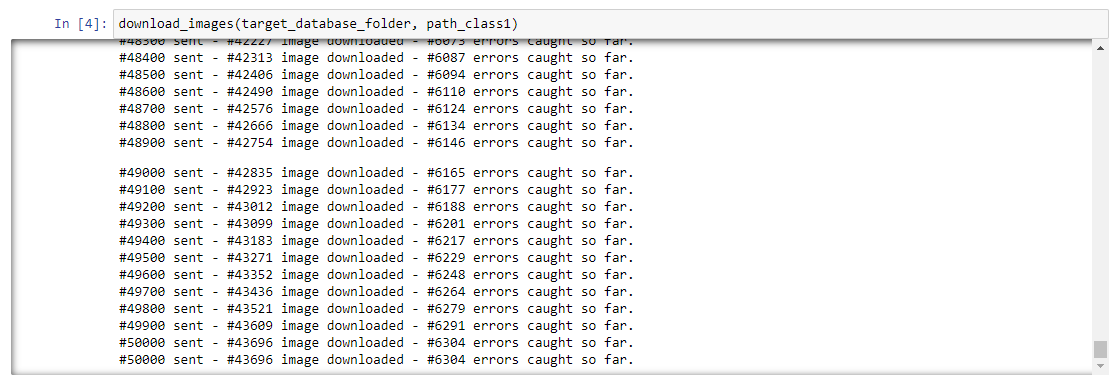

In [2]:
Image("pictures/downloadPictureFailureRate.png", width=600)

### Project Dataset

To continue our project, we create a dataset comprised of two classes ``safe`` and ``unsafe`` pictures.

| Class ID | Class name | # of pictures downloaded |
| --- | --- | --- |
| 0 | unsafe | 43696 |
| 1 | safe | 44772 |
| | **TOTAL** | 88,468 |

## 3. Creating and Training a Model using Machine Learning

The problem at hand is that of a binary classifier -- an easy problem at first hand that becomes quite complicated to manage when applied to images. 

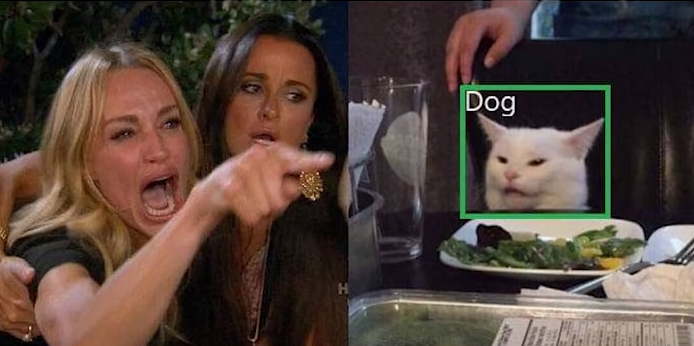

In [3]:
Image("pictures/meme.png", width=600)

*Yeah*, well, here we are. 

Furthermore, the goal here isn't to classify cats and dogs, but to classify pictures by capturing an **abstract sense of unsafeness**. Indeed, our effort won't only revolve around separating safe pictures from *clearly* unsafe ones, but safe ones from *questionable* pictures and more so. A hefty task at hand.

### Assumptions on the dataset

To do so, we must first assume that Derpibooru's tagging system is valid, and that no picture has slipped through the cracks of their moderation team and their report system. We can fairly be certain that ``safe`` pictures are indeed ``safe`` and ``unsafe`` pictures are indeed ``unsafe``. 

### Process

We will proceed as such:

1. **Image Preprocessing**. Using ``Keras``, preprocess the dataset into a training and validation set with a proportion of 80% and 20% of the images respectively (i.e. 70775 pictures will be used for training, 17693 for validation). The pictures will be sent to our model in **batches of 16** while being resized as **256 x 256 px** images.

2. **Build our model**. Our model is based on the textbook example provided by Keras [here](https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html)

```python
def make_model(input_shape, num_classes):
    """
    Function used to create our model
    """
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    # Entry block composed of the following layers:
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) # Rescaling layer
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same")(x) # Convolutional layer
    x = BatchNormalization()(x) # Batch Normalization layer
    x = Activation("relu")(x) # Activation layer
    x = Conv2D(64, kernel_size=(3, 3), padding="same")(x) # Convolutional layer
    x = BatchNormalization()(x) # Batch Normalization layer
    x = Activation("relu")(x) # Activation layer
    
    # Records a residual
    previous_block_activation = x

    # Creates 4 sets of block with different sizes for the breadth of the layer
    for size in [32, 64, 128, 256]:
        # first convolutional layer block
        x = layers.SeparableConv2D(size, kernel_size=(3, 3), padding="same")(x) # Convolutional layer
        x = BatchNormalization()(x) # Batch Normalization layer
        x = Activation("relu")(x) # Activation layer
        
        # second convolutional layer block
        x = layers.SeparableConv2D(size, kernel_size=(3, 3), padding="same")(x) # Convolutional layer
        x = BatchNormalization()(x) # Batch Normalization layer
        x = Activation("relu")(x) # Activation layer
        
        x = MaxPooling2D((3, 3), strides=2, padding="same")(x) # Max Pooling layer

        # Residual block
        residual = Conv2D(size, kernel_size=(1, 1), strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Adds back residual
        previous_block_activation = x  # Records a residual

    # Last Convolutional layer
    x = layers.SeparableConv2D(128, kernel_size=(3, 3), padding="same")(x) # Convolutional layer
    x = BatchNormalization()(x) # Batch Normalization layer
    x = Activation("relu")(x) # Activation layer

    x = layers.GlobalAveragePooling2D()(x) # Average Pooling Layer
    
    # Dense Layer
    activation = "sigmoid"
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation=activation)(x)
```

As such we obtain the following architecture:

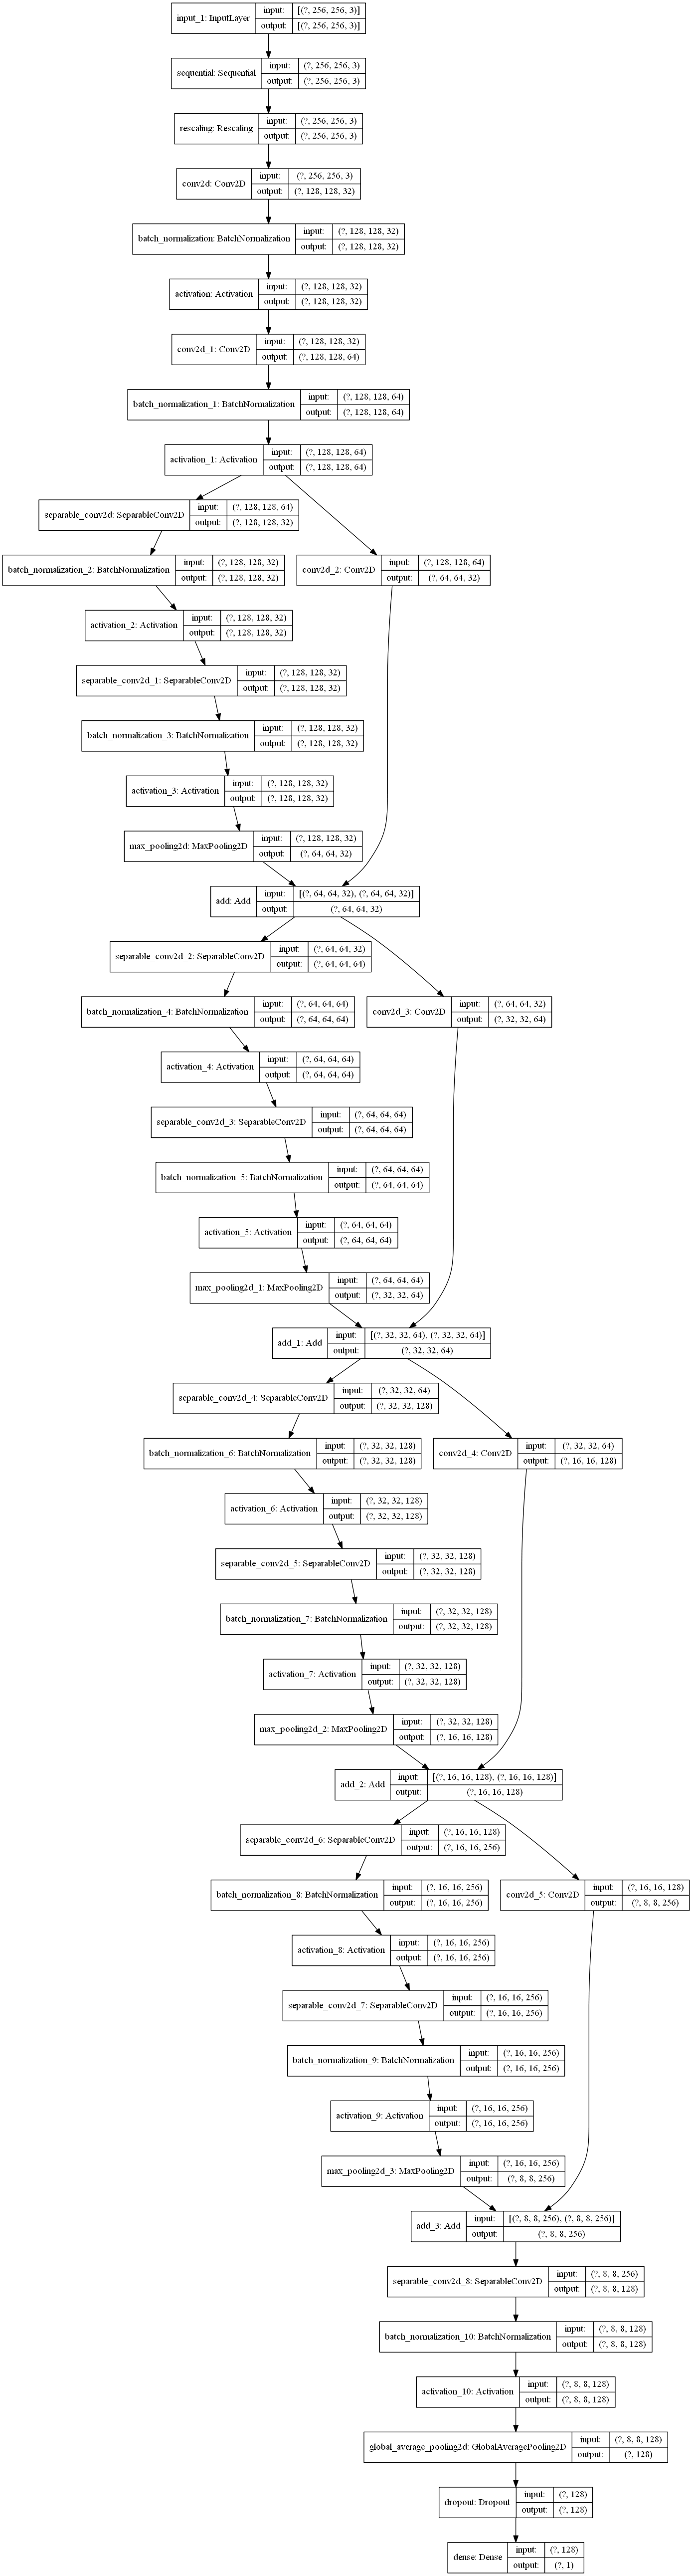

In [4]:
Image("pictures/model.png", width=600)

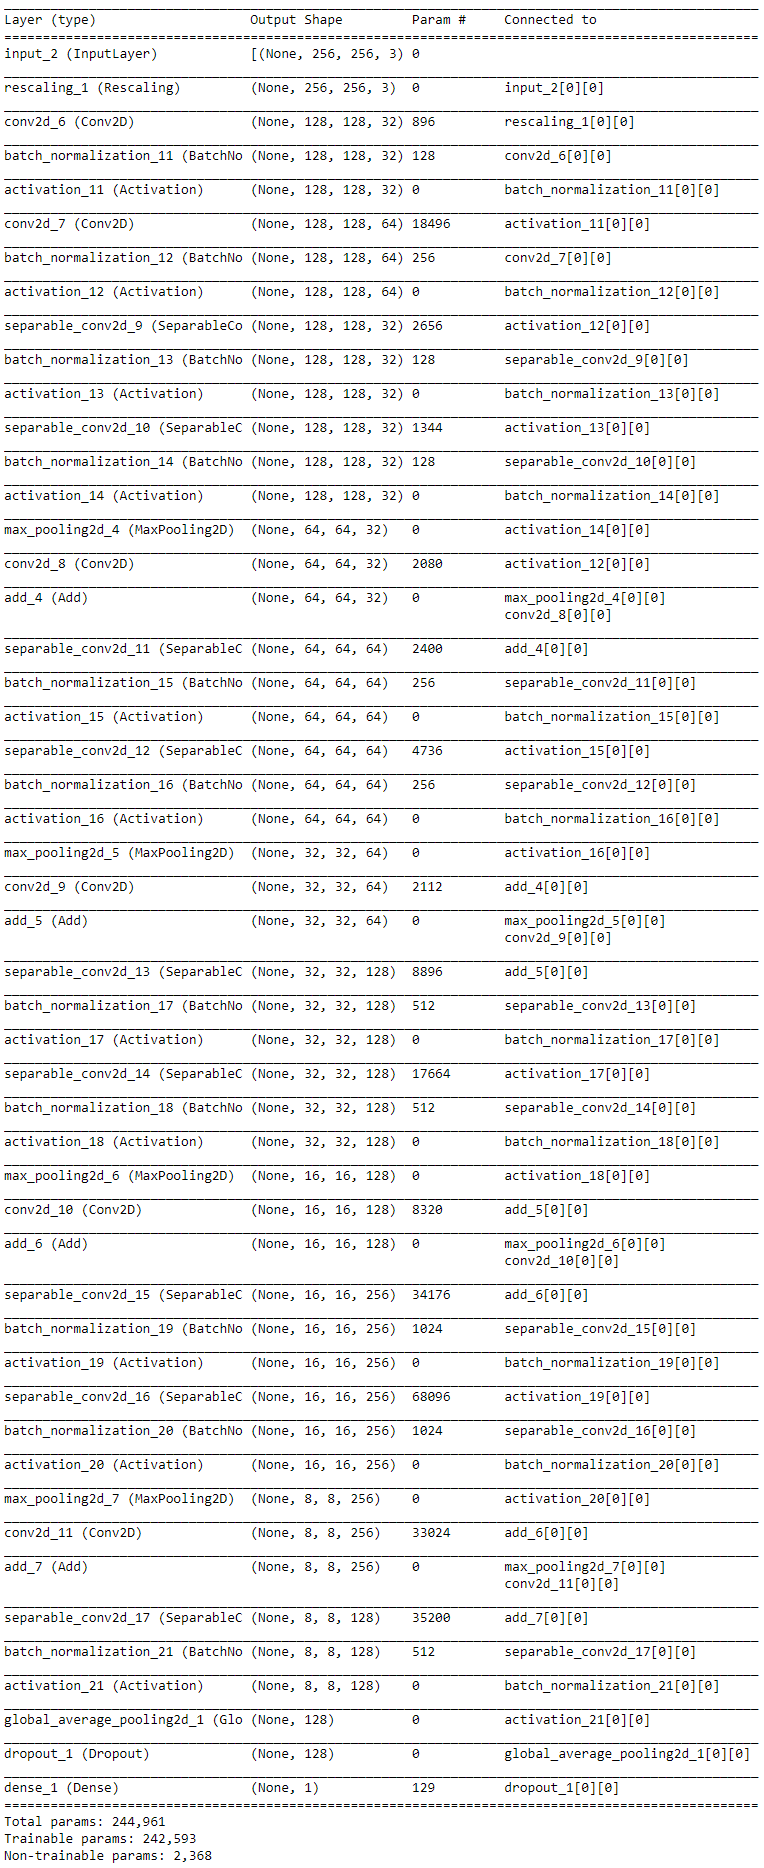

In [5]:
Image("pictures/modelParameters.png", width=600)

3. **Train our model**. Our model is compiled using an **Adam** optimizer, **binary Cross Entropy** loss, with our metric being **accuracy**. We train our model for **60** epochs (one epoch took c. 3000 seconds -- i.e. c. 50 hours). 

4. **Testing our model**. To test our model, we go back to our step 2, downloading 3000 pictures that were not included in the training and validation datasets. Due to the failure rate, we end up with a test datasets composed of the following:

| Class ID | Class name | # of pictures downloaded |
| --- | --- | --- |
| 0 | unsafe | 1310  |
| 1 | safe | 1333  |
| | **TOTAL** | 2643 |

We focus on 4 metrics:

1. **False Negative ratio**: Type 2 error
2. **Accuracy**: Model accuracy score represents the model’s ability to correctly predict both the positives and negatives out of all the predictions.
3. **Precision**: Model precision score represents the model’s ability to correctly predict the positives out of all the positive prediction it made. 
4. **Recall**: Model recall score represents the model’s ability to correctly predict the positives out of actual positives.
5. **F1 Score**: Model F1 score represents the model score as a function of precision and recall score. This is useful measure of the model in the scenarios where one tries to optimize either of precision or recall score and as a result, the model performance suffers.

### Results

In [6]:
df = pd.read_csv("test_results_2020_11_11.csv")
df = df.drop(df.columns[0], axis =1)

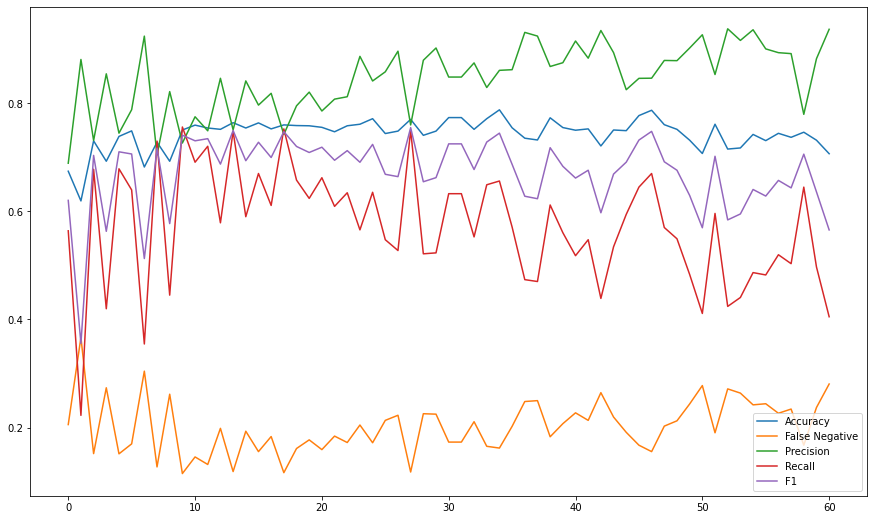

In [7]:
df.plot(figsize=(15,9))

In [8]:
df.nsmallest(5, "False Negative", keep='first')

,Accuracy,False Negative,Precision,Recall,F1
9,0.749898,0.115432,0.725833,0.755421,0.740331
17,0.759312,0.117069,0.741660,0.751951,0.746770
27,0.769546,0.118297,0.759227,0.749350,0.754256
13,0.763406,0.119116,0.750218,0.747615,0.748914
7,0.727384,0.127712,0.703766,0.729402,0.716354


In [9]:
df.nlargest(5, "Accuracy", keep='first')

,Accuracy,False Negative,Precision,Recall,F1
34,0.787147,0.162505,0.860068,0.655681,0.744094
46,0.786328,0.155956,0.845564,0.669558,0.747338
45,0.776504,0.167826,0.845279,0.644406,0.731299
30,0.772820,0.173557,0.847674,0.632264,0.724292
31,0.772820,0.173557,0.847674,0.632264,0.724292


In [10]:
df.nlargest(5, "Precision", keep='first')

,Accuracy,False Negative,Precision,Recall,F1
52,0.714695,0.271797,0.936782,0.424111,0.583881
60,0.706099,0.280802,0.935872,0.405030,0.565375
54,0.741711,0.242325,0.935000,0.486557,0.640046
42,0.720426,0.264838,0.933579,0.438855,0.597050
36,0.734752,0.248465,0.930153,0.473547,0.627586


In [11]:
df.nlargest(5, "Recall", keep='first')

,Accuracy,False Negative,Precision,Recall,F1
9,0.749898,0.115432,0.725833,0.755421,0.740331
17,0.759312,0.117069,0.741660,0.751951,0.746770
27,0.769546,0.118297,0.759227,0.749350,0.754256
13,0.763406,0.119116,0.750218,0.747615,0.748914
7,0.727384,0.127712,0.703766,0.729402,0.716354


In [12]:
df.nlargest(5, "F1", keep='first')

,Accuracy,False Negative,Precision,Recall,F1
27,0.769546,0.118297,0.759227,0.749350,0.754256
13,0.763406,0.119116,0.750218,0.747615,0.748914
46,0.786328,0.155956,0.845564,0.669558,0.747338
17,0.759312,0.117069,0.741660,0.751951,0.746770
34,0.787147,0.162505,0.860068,0.655681,0.744094


**Conclusion**: Based on these results, it seems that the model obtained at the **epoch 27** (starting with epoch 0) is the best trade-off we managed to achieve.

### Example of inference on two images (one false positive, one true negative)

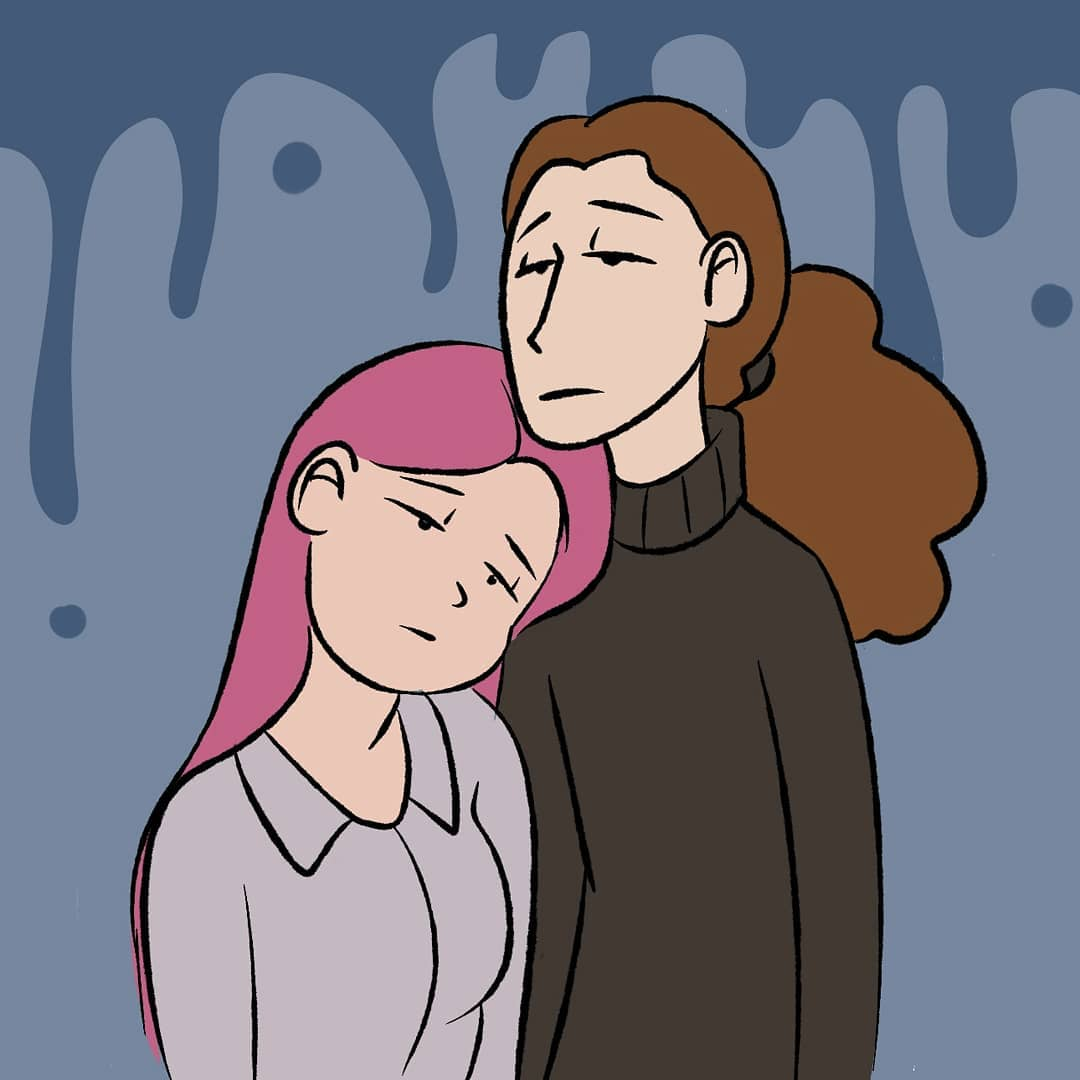

In [13]:
Image("pictures/test_example_1.jpg", width=300)

Source: [Smol_andriusha](https://www.derpibooru.org/images/2486593)

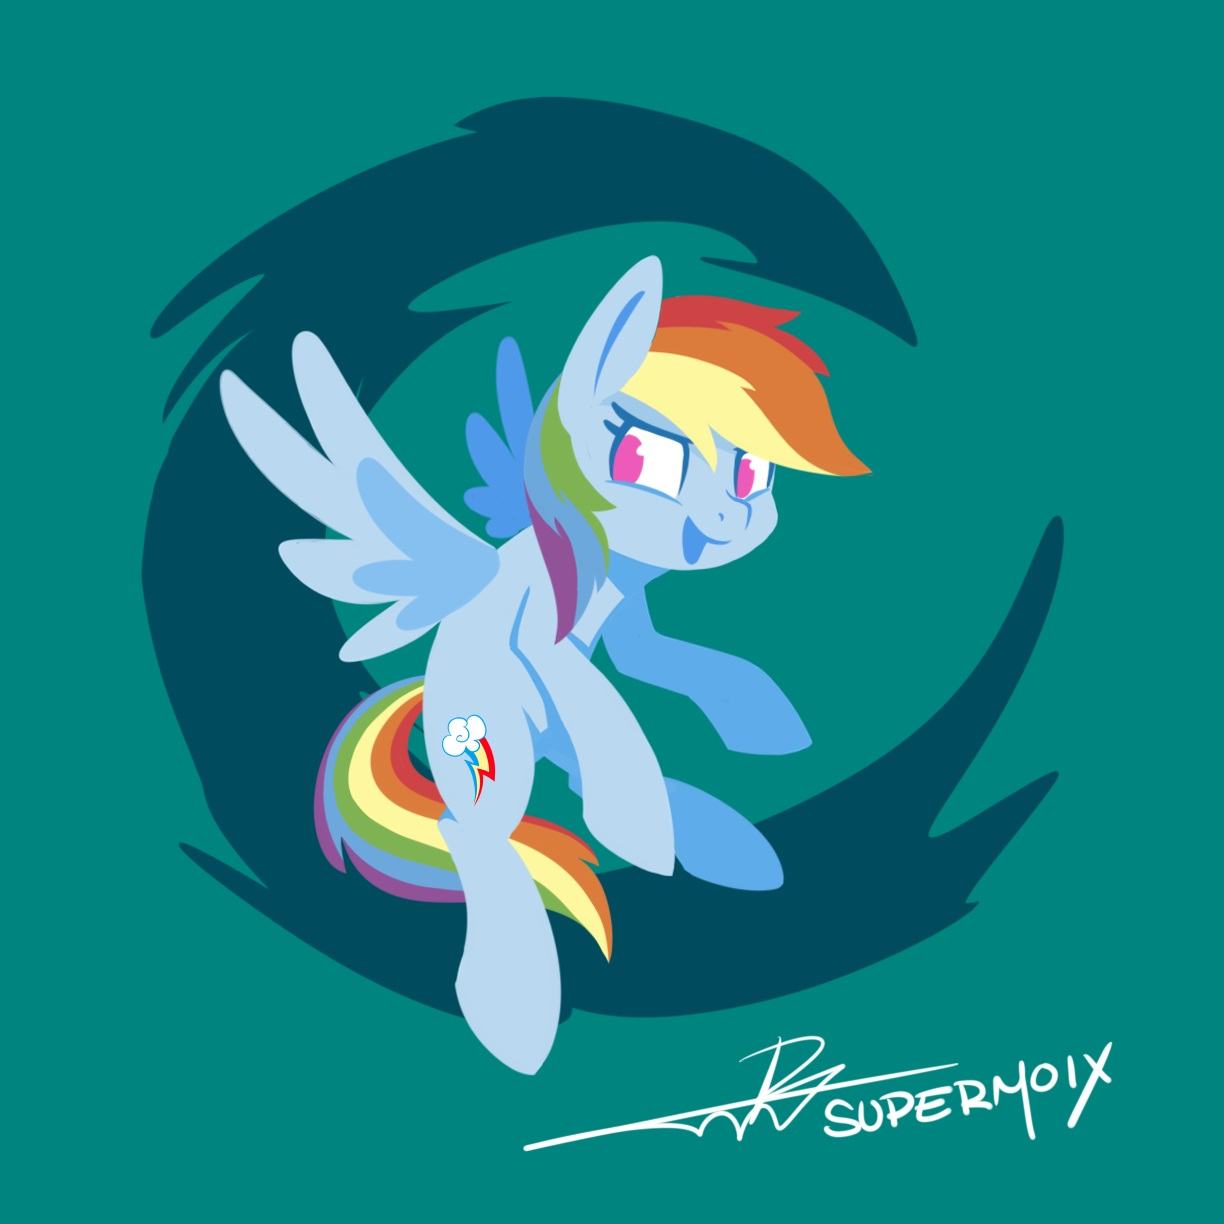

In [14]:
Image("pictures/test_example_2.jpg", width=300)

Source: [supermoix](https://www.derpibooru.org/images/2440655)

In [15]:
score1 = run_inference("selected_model.h5", "pictures/test_example_1.jpg")
score2 = run_inference("selected_model.h5", "pictures/test_example_2.jpg")
print(
    "The first example is %.2f percent unsafe and %.2f percent safe."
    % (100 * (1 - score1), 100 * score1)
)
print(
    "The second example is %.2f percent unsafe and %.2f percent safe."
    % (100 * (1 - score2), 100 * score2)
)

The first example is 57.43 percent unsafe and 42.57 percent safe.
The second example is 4.35 percent unsafe and 95.65 percent safe.


## 4. Implementing a Bot With an Image Classification Function

Now that we have a proof of work classifier, we can implement a working bot on Discord which can reply to user inputs, i.e. messages and images. To do so we use the available app and library provided by Discord [here](https://discordpy.readthedocs.io/en/latest/).

Our bot will have common functionalities: 

| Functions | Descriptions |
| ------ | ------ |
| !help | Describes the functions currently available to the bot |
| ?info | A more interactive help |
| !avatar | Cites the reddit account of the bot's avatar |
| !roll ``<val>d<val>`` | Dice rolling function |

As well has an image detection implementation. 

| Functions | Descriptions |
| ------ | ------ |
| *ML detection* | Provides a ML-modeled result for each picture directly uploaded to discord |

And we will call this bot: **botjack**.

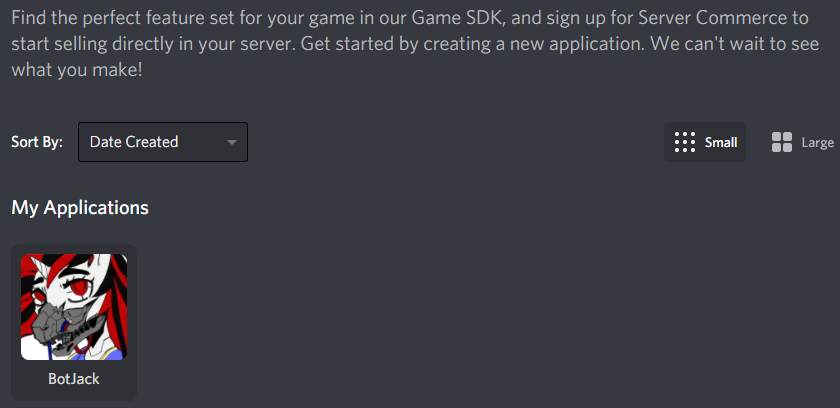

In [3]:
Image("pictures/bot_app_1.png")

Our bot can easily be started in the command line using: 

```shell
$> python main.py```

It will start loading its libraries, including Tensorflow and the image classification model.

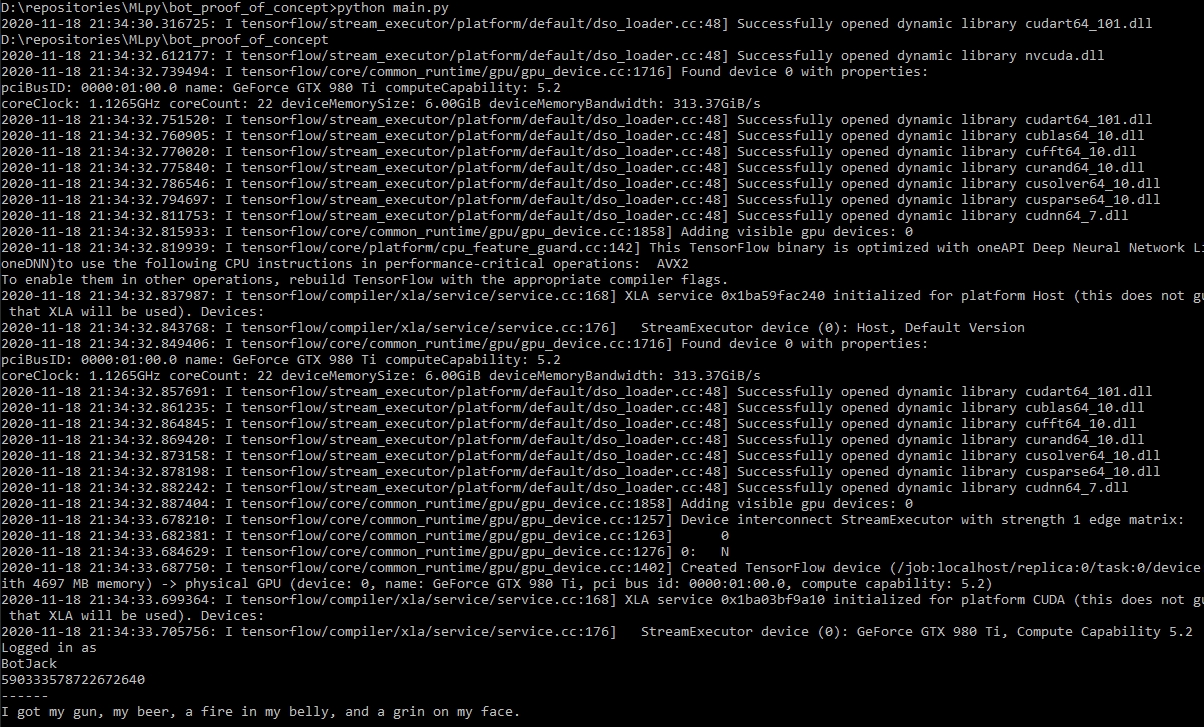

In [4]:
Image("pictures/bot_app_2.png")

Input is read by the bot and reacted to if instructed to. For instance via the command mentioned above:

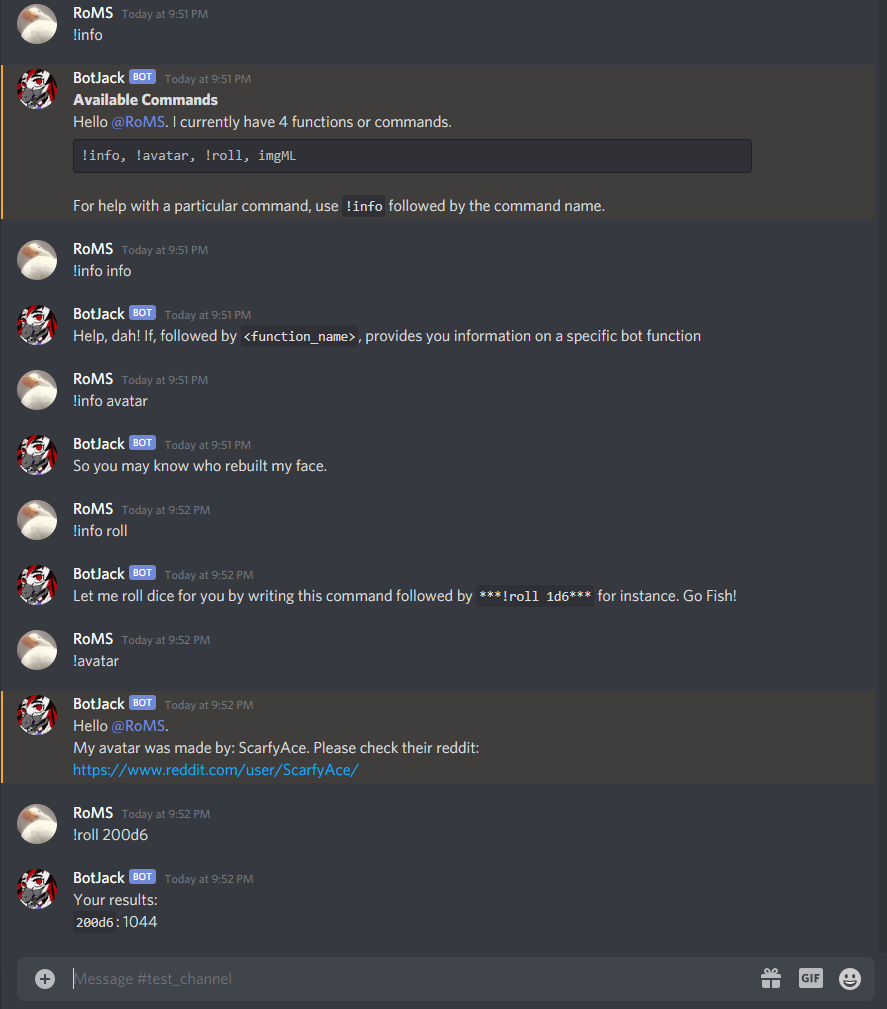

In [6]:
Image("pictures/bot_app_3.png")

### Having the bot react to images

Now, the real use of BotJack is reacting to posted images on the Discord channel. Indeed, for every image posted, BotJack will retrieve it and test it through the model we've trained earlier. Given the result it will output an answer.

**Example 1:** A Tintin comics crossover with the video game Among Us.

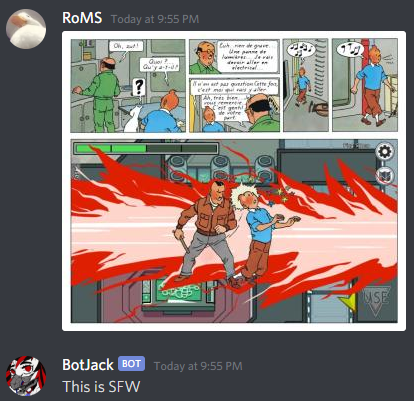

In [9]:
Image("pictures/bot_app_4.png", width=350)

**Example 2:** A philosophy meme

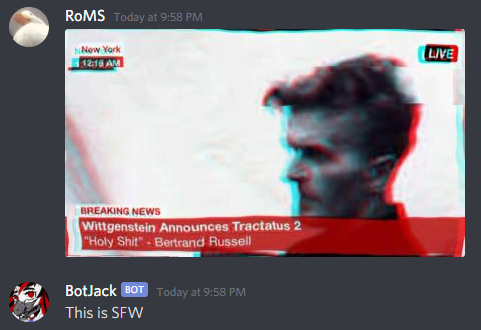

In [11]:
Image("pictures/bot_app_5.png", width=400)

**Example 3:** A false positive with regards to unsafe content

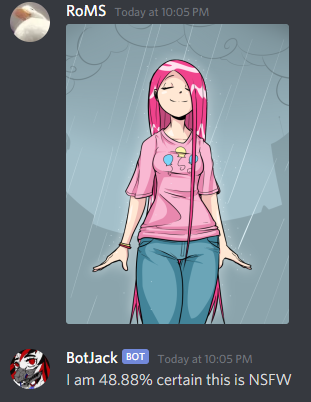

In [12]:
Image("pictures/bot_app_6.png")

**Example 4:** A screenshop from an anime movie: Red Line

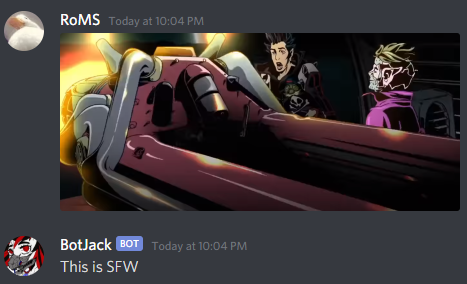

In [13]:
Image("pictures/bot_app_7.png")

## 5. Conclusion!

We now have our working model, our working bot, and we learned a lot along the way!

### Hurdles

- Hardware: training the model took roughly 50h on a GTX980ti.Having more memory and a better graphics card to be used by the tensorflow library would accelerate the process

- Retrieving the data from the image repository took several days to fit their Terms of Service. Downloading the whole derpibooru database would take the module implemented in this repository c. 23 days.

### Ways to improve the model

- Increasing the size of inputs and the number of layer (and layer dimensions) could increase the predictive power of the model. The trade-off, again, would be the training length, which is currently bottlenecked by the hardware we have at our disposition.

### Ways to improve the bot

- New functionalities could be implemented for the bot such as an automated moderation response workflow:

    1. a picture is posted
    2. the bot downloads the picture
    3. the bot analyzes the picture through its recorded model
    4. if the picture is deemed NSFW:
        - record the message that may have accompanied the picture
        - delete the picture from the chat
        - repost the picture and the affiliated text spoilered
        - ping the moderators of the chat for investigation


- Implement a way to restrict the bot to some channels of a server